In [1]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.io import loadmat
from scipy.ndimage import convolve, gaussian_filter1d, gaussian_filter
from scipy.signal import butter, filtfilt, freqz, lfilter, spectrogram, iirnotch, hilbert, savgol_filter, normalize, resample
import statistics

# These 3 lines allow editing of the utils file without having to restart the Jupyter kernel.
%reload_ext autoreload
%autoreload 1
%aimport utils
import utils

# Better plotting.
%matplotlib ipympl

In [2]:
# Constants related to .mat structs.
CAI_SB1 = "caillouSB1_1117.mat"
BLUE_SB2 = "blueSB2_0328.mat"
BLUE_LFP0_IDX = ["RSX", "RSX", "", "", "SMX", "SMX", "SMX", "SMX"]
BLUE_LFP1_IDX = ["SMX", "SMX", "HIP", "", "", "RSX", "RSX", "RSX"]
CAI_SB1_LFPJ_IDX = ["THA", "THA", "RSX", "RSX", "RSX", "RSX", "RSX", "RSX"]
CAI_SB1_LFPK_IDX = ["RSX", "RSX", "RSX", "RSX", "RSX", "RSX", "HIP", "HIP"]
CAI_SB1_LFP0_IDX = ["HIP"]*8
LFP_NAMES = ["adlfpj", "adlfpk", "arlfp0", "arlfp1"]

# Hippocampus bandpass filter params.
HC_FILTER_LOW = 100
HC_FILTER_HI = 250
HC_FILTER_ORDER = 9

In this notebook, we'll add some basic methods to detect ripples. First load data.

In [3]:
sb1_struct = loadmat(CAI_SB1, struct_as_record=False)
sb1_time, sb1_data, sample_rate = utils.get_data(sb1_struct, name=LFP_NAMES[1])  # RSX and HIP

# Filter HC 
sb1_data[:, 6] = utils.butter_filter(sb1_data[:, 6], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER, type="bandpass")
sb1_data[:, 7] = utils.butter_filter(sb1_data[:, 7], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER, type="bandpass")
lfp = sb1_data[:, 6]

# Load RSX firing rate data.
rsxfr_time = np.squeeze(sb1_struct["RSXfr"][0][0].timestamp)
rsxfr_count = np.squeeze(sb1_struct["RSXfr"][0][0].count)
rsxfr_data = np.squeeze(sb1_struct["RSXfr"][0][0].data)

In [4]:
rsxfr_time = np.squeeze(sb1_struct["RSXfr"][0][0].timestamp)
rsxfr_count = np.squeeze(sb1_struct["RSXfr"][0][0].count)
rsxfr_data = np.squeeze(sb1_struct["RSXfr"][0][0].data)

Calculate the envelope of the hippocampal LFP, smooth it, then get mean and standard deviation

In [5]:
lfp = sb1_data[:, 6]
analytic_signal = hilbert(lfp)
amplitude_envelope = np.abs(analytic_signal)
smoothed = savgol_filter(amplitude_envelope, 101, 3)
mean = np.mean(amplitude_envelope)
std = statistics.stdev(smoothed)

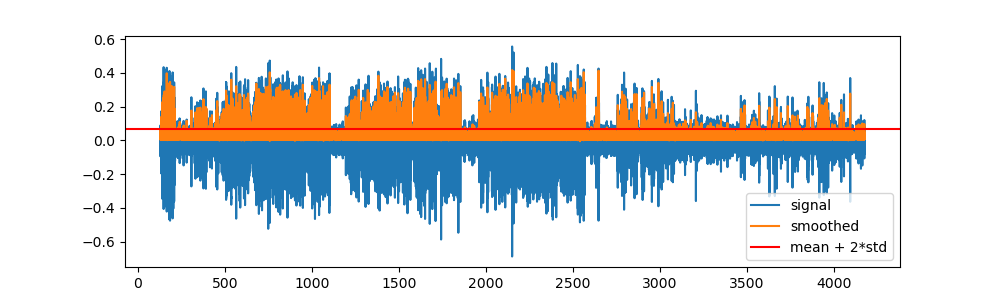

In [6]:
plt.close()
# Plot smoothed and normal signal
fig = plt.gcf()
fig.canvas.header_visible = False
fig.set_size_inches((10, 3))

plt.plot(sb1_time, lfp, label="signal")
plt.plot(sb1_time, smoothed, label="smoothed")
plt.axhline(mean+2*std, color="r", label="mean + 2*std")
plt.legend(loc="best")
plt.show()

Classify ripples and merge ones that are close together.

In [7]:
thresh = mean + 2*std  # Tunable.
ripples = np.where(smoothed >= thresh, 1, 0)
boundaries_list = []

for i in range(len(amplitude_envelope)-1):
    if ripples[i] != ripples[i+1]:
        boundaries_list.append(i)

# Make them into list of tuples for easier indexing.
boundaries = [tuple(boundaries_list[i:i+2]) for i in range(0, len(boundaries_list), 2)]

# The following code merges blocks that are min_dist apart (measured from 
# current ripple beginning to next ripple beginning). Two while loops because
# ther are often multiple blocks that need to be merged.
min_dist = sample_rate * 0.2  # Tunable.
merged = []
i = 0
while i < len(boundaries)-2:
    dist = boundaries[i+1][0]-boundaries[i][0]  # Compare current begnning and next beginning
    if dist < min_dist:
        j = 0
        while boundaries[i+j+1][0] - boundaries[i+j][0] < min_dist:
            j+=1
        merged.append(boundaries[i][0])
        merged.append(boundaries[i+j][1])
        i+=1+j
    else:  
        merged.append(boundaries[i][0])
        merged.append(boundaries[i][1])
        i+=1
merged = np.array(merged)

Quick visualization of merged boundaries.

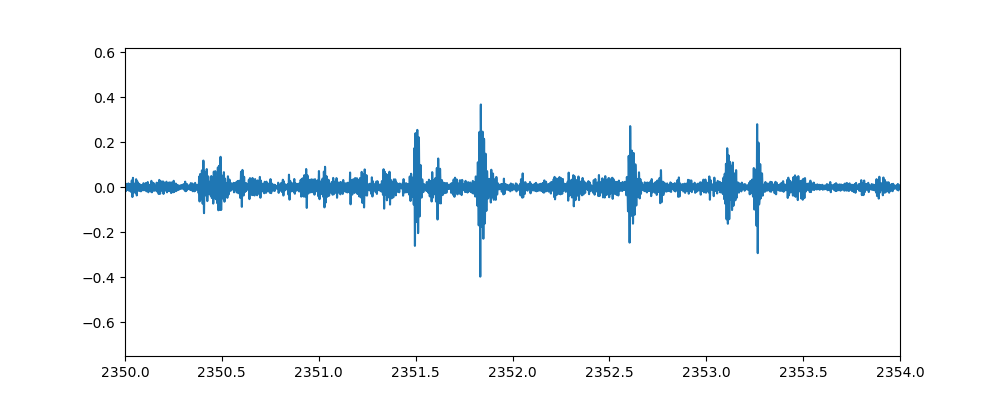

In [15]:
plt.close()
ax = plt.gca()
fig = plt.gcf()
fig.canvas.header_visible = False
plt.plot(sb1_time, lfp)
plt.xlim(2350, 2354)
fig.set_size_inches((10, 4))
plt.show()
for line in merged:
    ax.axvline(sb1_time[line], color="red", lw=1, alpha=0.2)

Quick visualizartion of distribution of rippple duration.

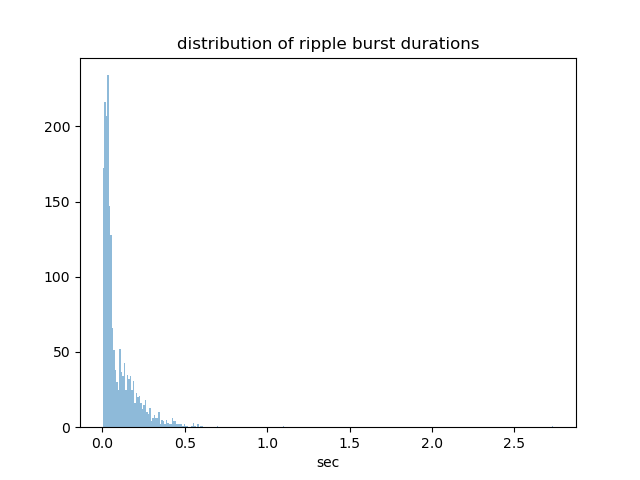

In [16]:
plt.close()
fig = plt.gcf()
fig.canvas.header_visible = False

distances = []
for i in np.linspace(0, len(merged)-2, (len(merged))//2, dtype=np.int64):
    distances.append(merged[i+1]-merged[i])
distances = np.array(distances)

plt.hist(np.array(distances)/sample_rate, bins=300, alpha=0.5)
plt.title("distribution of ripple burst durations")
plt.xlabel("sec")
plt.show()

In [17]:
# Define thresholds (TODO: tune these, currently pretty arbitrary).
thresh0 = 280
thresh1 = 480
thresh2 = 800

# Separate singlets, doublets, triplets, and long ripple bursts.
singles_idx = np.asarray(distances < thresh0)
doubles_idx = np.asarray(np.logical_and(distances >=
                     thresh0, distances < thresh1))
triples_idx = np.asarray(np.logical_and(distances >=
                     thresh1, distances < thresh2))
longs_idx = np.asarray(distances >= thresh2)

# There are probably more efficient ways to do this, but just getting correct indices.
singles = []
for id in singles_idx:
    singles.append(id)
    singles.append(id)
singles = merged[singles]

doubles = []
for id in doubles_idx:
    doubles.append(id)
    doubles.append(id)
doubles = merged[doubles]

triples = []
for id in triples_idx:
    triples.append(id)
    triples.append(id)
triples = merged[triples]

longs = []
for id in longs_idx:
    longs.append(id)
    longs.append(id)
longs = merged[longs]

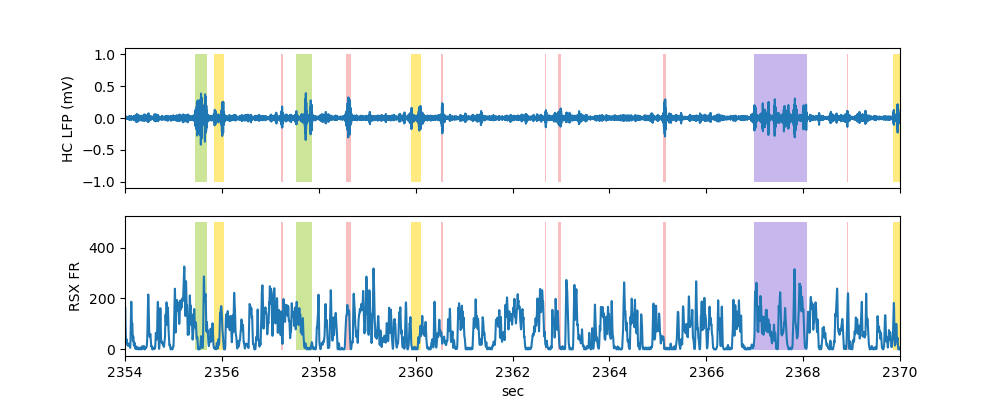

In [19]:
plt.close()
red_patch = mpatches.Patch(color='lightcoral', label='singlet')
yellow_patch = mpatches.Patch(color='gold', label='doublet')
green_patch = mpatches.Patch(color='yellowgreen', label='triplet')
purple_patch = mpatches.Patch(color='mediumpurple', label='4+')
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches((10, 4))
fig.canvas.header_visible = False

axes[0].set_xlim(2354, 2370)
axes[0].plot(sb1_time, lfp)
axes[0].set_ylabel("HC LFP (mV)")
axes[1].plot(rsxfr_time, rsxfr_data)
axes[1].set_ylabel("RSX FR")

# Plotting the legend slows things down.
# axes[0].legend(handles=[red_patch, yellow_patch, green_patch, purple_patch], loc="best")
# axes[1].legend(handles=[red_patch, yellow_patch, green_patch, purple_patch], loc="best")

# Plot colored boxes.
i = 0
while i < len(singles):
    rect0 = Rectangle((sb1_time[singles[i]], -1), width=(sb1_time[singles[i+1]] -
                     sb1_time[singles[i]]), height=2, facecolor='lightcoral', alpha=0.5)
    rect1 = Rectangle((sb1_time[singles[i]], -1), width=(sb1_time[singles[i+1]] -
                     sb1_time[singles[i]]), height=500, facecolor='lightcoral', alpha=0.5)
    axes[0].add_patch(rect0)
    axes[1].add_patch(rect1)
    i += 2
i = 0
while i < len(doubles):
    rect0 = Rectangle((sb1_time[doubles[i]], -1), width=sb1_time[doubles]
                     [i+1]-sb1_time[doubles][i], height=2, facecolor='gold', alpha=0.5)
    rect1 = Rectangle((sb1_time[doubles[i]], -1), width=sb1_time[doubles]
                     [i+1]-sb1_time[doubles][i], height=500, facecolor='gold', alpha=0.5)
    axes[0].add_patch(rect0)
    axes[1].add_patch(rect1)
    i += 2
i = 0
while i < len(triples):
    rect0 = Rectangle((sb1_time[triples[i]], -1), width=sb1_time[triples]
                     [i+1]-sb1_time[triples][i], height=2, facecolor='yellowgreen', alpha=0.5)
    rect1 = Rectangle((sb1_time[triples[i]], -1), width=sb1_time[triples]
                     [i+1]-sb1_time[triples][i], height=500, facecolor='yellowgreen', alpha=0.5)
    axes[0].add_patch(rect0)
    axes[1].add_patch(rect1)
    i += 2
i = 0
while i < len(longs):
    rect0 = Rectangle((sb1_time[longs[i]], -1), width=sb1_time[longs]
                     [i+1]-sb1_time[longs][i], height=2, facecolor='mediumpurple', alpha=0.5)
    rect1 = Rectangle((sb1_time[longs[i]], -1), width=sb1_time[longs]
                     [i+1]-sb1_time[longs][i], height=500, facecolor='mediumpurple', alpha=0.5)
    axes[0].add_patch(rect0)
    axes[1].add_patch(rect1)
    i += 2

plt.xlabel("sec")
plt.show()


Look at RSX FR correspondance with ripples. This is just a rough first pass; these need to be normalized better first.

/Users/galen/Synology/research/rat_sleep/utils.py:160: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.min(data)) / (np.max(data) - np.min(data))


Text(0, 0.5, 'longs')

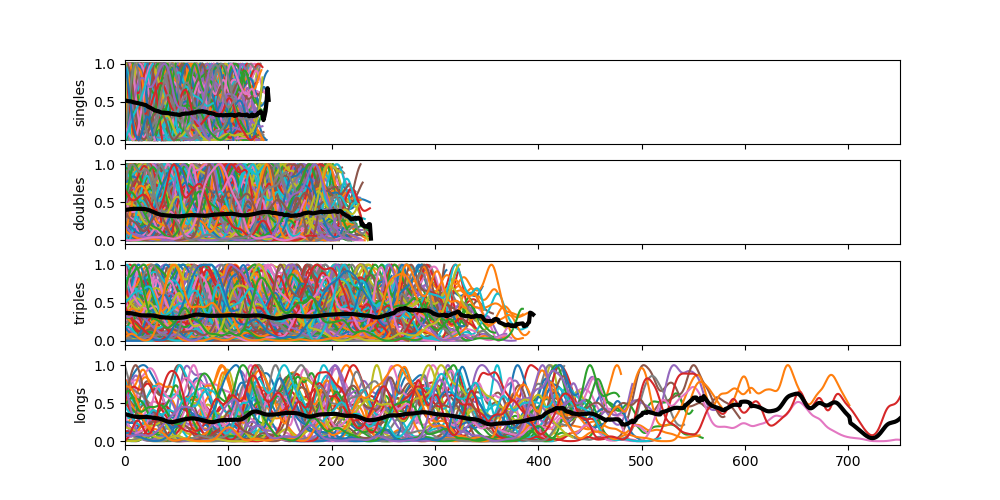

In [27]:
plt.close()
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
fig.canvas.header_visible = False
fig.set_size_inches((10, 5))
axes[0].set_xlim((0, 750))

# singles
single_events = []
i = 0
while i < len(singles):
    single_events.append(rsxfr_data[utils.lfp_sample2fr_sample(
        singles[i], sb1_time, rsxfr_time):utils.lfp_sample2fr_sample(singles[i+1], sb1_time, rsxfr_time)])
    i += 2
single_events = [utils.normalize(event) for event in single_events[2:]]
max_len = len(max(single_events, key=len))
padded = []
for event in single_events:
    # pad every event to same length
    axes[0].plot(event)
    pad = np.pad(event, (0, max_len-len(event)), constant_values=(np.nan))
    padded.append(pad)
axes[0].plot(np.nanmean(padded, axis=0), lw=3, color="black")
axes[0].set_ylabel("singles");

#doubles
double_events = []
i = 0
while i < len(doubles):
    double_events.append(rsxfr_data[utils.lfp_sample2fr_sample(
        doubles[i], sb1_time, rsxfr_time):utils.lfp_sample2fr_sample(doubles[i+1], sb1_time, rsxfr_time)])
    i += 2
double_events = [utils.normalize(event) for event in double_events]
max_len = len(max(double_events, key=len))
padded = []
for event in double_events:
    # pad every event to same length
    axes[1].plot(event)
    pad = np.pad(event, (0, max_len-len(event)), constant_values=(np.nan))
    padded.append(pad)
axes[1].plot(np.nanmean(padded, axis=0), lw=3, color="black")
axes[1].set_ylabel("doubles");

# triples
triple_events = []
i = 0
while i < len(triples):
    triple_events.append(rsxfr_data[utils.lfp_sample2fr_sample(
        triples[i], sb1_time, rsxfr_time):utils.lfp_sample2fr_sample(triples[i+1], sb1_time, rsxfr_time)])
    i += 2
triple_events = [utils.normalize(event) for event in triple_events]
max_len = len(max(triple_events, key=len))
padded = []
for event in triple_events:
    # pad every event to same length
    axes[2].plot(event)
    pad = np.pad(event, (0, max_len-len(event)), constant_values=(np.nan))
    padded.append(pad)
axes[2].plot(np.nanmean(padded, axis=0), lw=3, color="black")
axes[2].set_ylabel("triples");

# longs
long_events = []
i = 0
while i < len(longs):
    long_events.append(rsxfr_data[utils.lfp_sample2fr_sample(
        longs[i], sb1_time, rsxfr_time):utils.lfp_sample2fr_sample(longs[i+1], sb1_time, rsxfr_time)])
    i += 2
long_events = [utils.normalize(event) for event in long_events]
max_len = len(max(long_events, key=len))
padded = []
for event in long_events:
    #     # pad every event to same length
    axes[3].plot(event)
    pad = np.pad(event, (0, max_len-len(event)), constant_values=(np.nan))
    padded.append(pad)
axes[3].plot(np.nanmean(padded, axis=0), lw=3, color="black")
axes[3].set_ylabel("longs");


Now we look for spindles. First find periods of spike silence.

In [21]:
eps = 15  # Tolerance for what we count as silence, tunable.
thresh = 60  # Minimum length of silence, tunable.
suppressed = np.where(rsxfr_data <= eps, 1, 0)

i = 0
prev = 0
ones_count = 0
blocks = []
while i < len(rsxfr_data):
    if suppressed[i] == 1:
        ones_count+=1
    else:  # if current value is 0
        if prev == 1:
            if ones_count > thresh:
                blocks.append((i-1-ones_count, i-1))       
            ones_count = 0
    prev = suppressed[i]
    i+=1

Beginning attempt to identify spindles. 

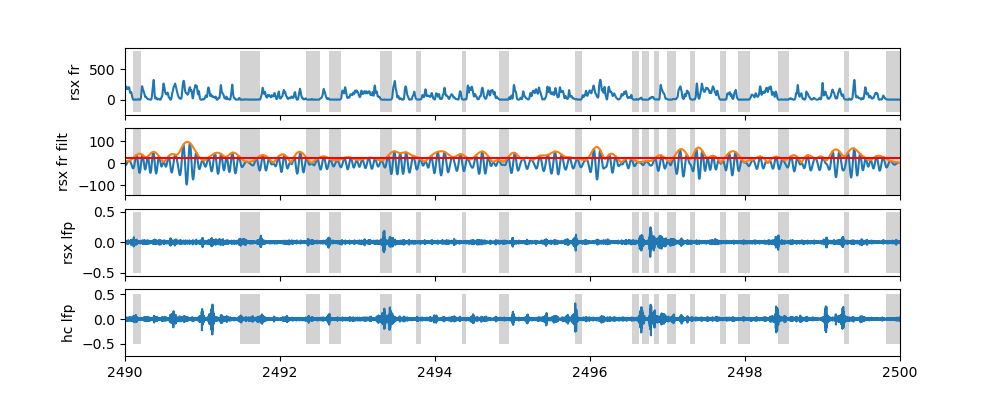

In [26]:
plt.close()
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
fig.canvas.header_visible = False
fig.set_size_inches((10, 4))

plt.xlim(2490, 2500)
axes[0].plot(rsxfr_time, rsxfr_data)
axes[0].set_ylabel("rsx fr")
for block in blocks:
    rect = Rectangle((rsxfr_time[block[0]], -200), width=rsxfr_time[block[1]] -
                     rsxfr_time[block[0]], height=1000, facecolor='lightgrey')
    axes[0].add_patch(rect)

# Calculate envelope for RSX FR.
fr_filt = utils.butter_filter(rsxfr_data, 9, 15, 1000, order=3)  # Filter between 9 and 15 Hz.
envelope = np.abs(hilbert(fr_filt))  # Take envelope.
mean = np.mean(envelope)  # Get mean.

axes[1].plot(rsxfr_time, fr_filt)
axes[1].plot(rsxfr_time, envelope)
axes[1].axhline(mean, color="red")  # Plot mean.
axes[1].set_ylabel("rsx fr filt")
for block in blocks:
    rect = Rectangle((rsxfr_time[block[0]], -200), width=rsxfr_time[block[1]] -
                     rsxfr_time[block[0]], height=600, facecolor='lightgrey')
    axes[1].add_patch(rect)

rsx_lfp_avg = sb1_data[:, -1]
axes[2].plot(sb1_time, rsx_lfp_avg)
axes[2].set_ylabel("rsx lfp")
for block in blocks:
    rect = Rectangle((rsxfr_time[block[0]], -0.5), width=rsxfr_time[block[1]] -
                     rsxfr_time[block[0]], height=1, facecolor='lightgrey')
    axes[2].add_patch(rect)

hc_lfp = utils.butter_filter(
    sb1_data[:, 6], lowcut=HC_FILTER_LOW, highcut=HC_FILTER_HI, fs=sample_rate, order=HC_FILTER_ORDER)
axes[3].plot(sb1_time, hc_lfp)
axes[3].set_ylabel("hc lfp")
for block in blocks:
    rect = Rectangle((rsxfr_time[block[0]], -0.5), width=rsxfr_time[block[1]] -
                     rsxfr_time[block[0]], height=1, facecolor='lightgrey')
    axes[3].add_patch(rect)
